In [1]:
from projectyl.dynamics.inverse_kinematics import build_arm_model
global_params = {}
build_arm_model(global_params, headless=False)
arm_robot = global_params["arm"]
viz = global_params["viz"]

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [2]:
import time 

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pinocchio as pin
from scipy.optimize import least_squares
from scipy.special import huber
from projectyl.utils.properties import ELBOW, SHOULDER, WRIST, RIGHT, LEFT
from projectyl.video.props import INTRINSIC_MATRIX
from projectyl.utils.arm import plot_optimization_curves
from pathlib import Path
from projectyl.dynamics.inverse_kinematics import build_arm_model, forward_kinematics
from projectyl.utils.arm import retrieve_arm_estimation
from projectyl.utils.camera_projection import project_3D_point
from projectyl.utils.pose_overlay import get_4D_homogeneous_vector
from projectyl.utils.io import Dump
from projectyl import root_dir
from projectyl.dynamics.inverse_dynamics import objective
from interactive_pipe.helper import _private
_private.registered_controls_names = [] # this is for notebooks where you re-execute cells everytime.

%load_ext autoreload
%autoreload 2



SIMULATION = "simulation"
REAL = "real"
camera_calibration_path = root_dir/"calibration"/"camera_calibration_xiaomi_mi11_ultra_video_vertical.json"
calib_dict = Dump.load_json(Path(camera_calibration_path))
intrinsic_matrix = np.array(calib_dict[INTRINSIC_MATRIX])
intrinsic_matrix


array([[1.69010663e+03, 0.00000000e+00, 5.34817898e+02],
       [0.00000000e+00, 1.69233647e+03, 9.43177198e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [3]:
mode = REAL
# video_path = Path(root_dir)/"__out/0009_weight_lifting_main_camera_30fps"
video_path = Path(root_dir)/"__out/0011_arm_calibration"
side = "right"

In [4]:
if mode == REAL:
    data3d = Dump.load_pickle(video_path/"coarse_ik.pkl")
    data2d = Dump.load_pickle(video_path/"pose"/"pose_sequence.pkl")
    # INITIAL STATE LIST
    q = np.array(data3d["q"])
    T = len(q)

    # 3D points
    p = ([np.array([el.translation for el in data3d["3dpoints"][member]]).T for member in [SHOULDER, ELBOW, WRIST]])
    gt_p_full = np.concatenate(p).T
    gt_p_full.shape #T, 9

    # initialization from IK estimation
    initial_full = np.concatenate([q, np.zeros((T, 2 * arm_robot.model.nv))], axis=1)
    initial_full.shape
    DT = 1/30. # 30fps


    # 2D points
    arm_2d = [retrieve_arm_estimation(data2d, frame_idx=t, arm_side=RIGHT, key="pose_landmarks") for t in range(len(data2d))]
    p2d = [np.array([el[member] for el in arm_2d]).T for member in [SHOULDER, ELBOW, WRIST]]
    gt_p2d_full = np.concatenate(p2d).T
    gt_p2d_full.shape

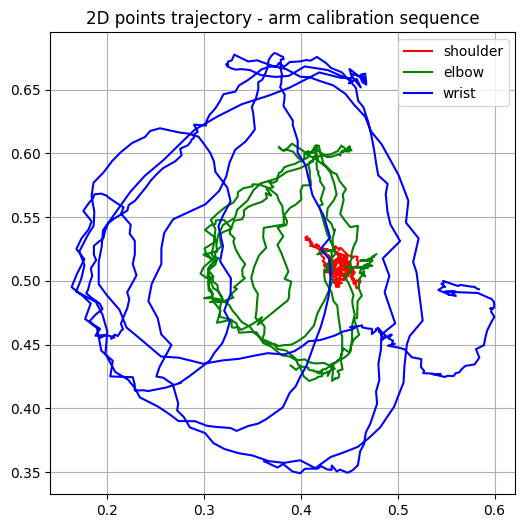

In [5]:
plt.figure(figsize=(6, 6))
t_start, t_end = 0, len(gt_p_full)

for joint_idx, joint_name in enumerate([SHOULDER, ELBOW, WRIST]):

    plt.plot(gt_p2d_full[t_start:t_end, joint_idx * 3 + 0], gt_p2d_full[t_start:t_end, joint_idx * 3 + 1], color="rgb"[joint_idx], label=f"{joint_name}")
# plt.xlim(0, 1)
# plt.ylim(1, 0)
plt.grid()
plt.legend()
plt.title("2D points trajectory - arm calibration sequence")
plt.show()

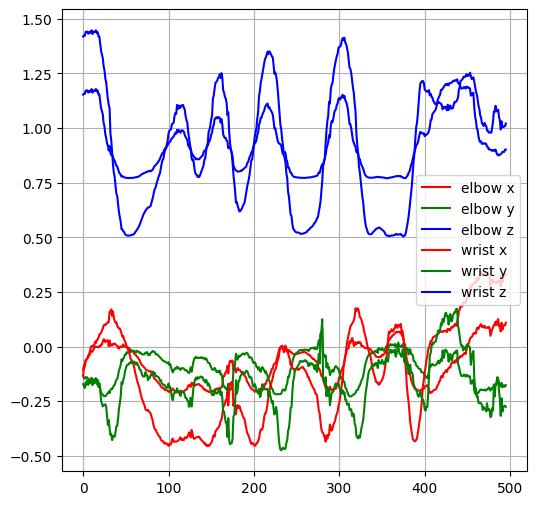

In [6]:

plt.figure(figsize=(6, 6))
for joint_idx, joint_name in enumerate([SHOULDER, ELBOW, WRIST]):
    if joint_idx == 0:
        continue
    for dim_idx, dim in enumerate("xyz"):
        plt.plot(gt_p_full[:, joint_idx * 3 + dim_idx], color="rgb"[dim_idx], label=f"{joint_name} {dim}")
plt.grid()
plt.legend()
plt.show()

In [7]:
extrinsic_matrix = np.zeros((3, 4))
extrinsic_matrix[:3, :3] = np.eye(3)
print(extrinsic_matrix)
cam_init = [0., -3., 1.]
cam_pos = get_4D_homogeneous_vector(cam_init)
extrinsic_matrix[:3, -1] = -cam_pos[:3, 0]
# pos = np.array([0., 0., 0.])
# project_3D_point(pos, intrinsic_matrix, extrinsic_matrix)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [8]:
# time_idx = 5
p2d_estim_list = {SHOULDER: [], ELBOW: [], WRIST: []}
p3d_estim_list = {SHOULDER: [], ELBOW: [], WRIST: []}
for time_idx in range(len(gt_p_full)):
    for frame_idx, frame in enumerate([SHOULDER, ELBOW, WRIST]):
        # q = np.array(data3d["q"])
        current_q = q[time_idx]
        point, jac = forward_kinematics(arm_robot, current_q, frame=frame)
        p3d = point.translation
        p3d_estim_list[frame].append(p3d)
        p2d = project_3D_point(p3d, intrinsic_matrix, extrinsic_matrix)
        p2d_estim_list[frame].append(p2d)
        # p2d_list[frame] = {"2d": p2d, COLOR: colors[frame_idx]}
for frame_idx, frame in enumerate([SHOULDER, ELBOW, WRIST]):
    p2d_estim_list[frame] = np.array(p2d_estim_list[frame])
    p3d_estim_list[frame] = np.array(p3d_estim_list[frame])

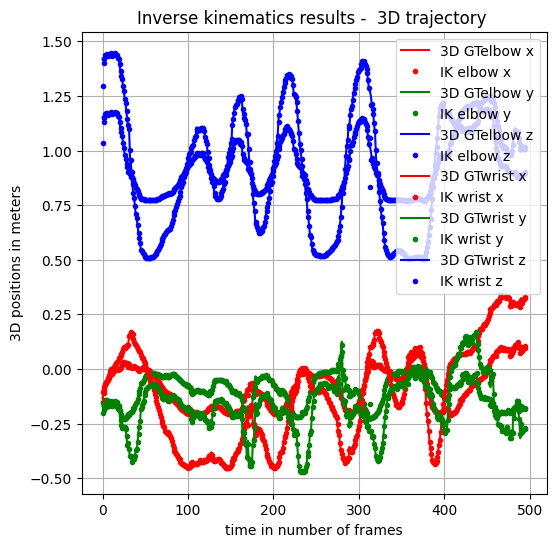

In [9]:

plt.figure(figsize=(6, 6))
for joint_idx, joint_name in enumerate([SHOULDER, ELBOW, WRIST]):
    if joint_idx == 0:
        continue
    for dim_idx, dim in enumerate("xyz"):
        plt.plot(gt_p_full[:, joint_idx * 3 + dim_idx], color="rgb"[dim_idx], label=f"3D GT{joint_name} {dim}")
        plt.plot(p3d_estim_list[joint_name][:, dim_idx], ".", color="rgb"[dim_idx], label=f"IK {joint_name} {dim}")
plt.ylabel("3D positions in meters")
plt.xlabel("time in number of frames")
plt.title("Inverse kinematics results -  3D trajectory ")
plt.grid()
plt.legend()
plt.show()

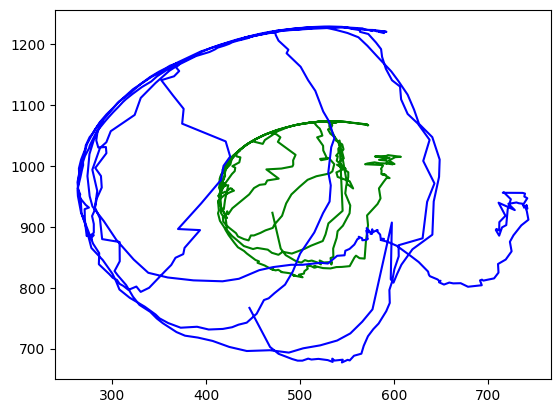

In [10]:
for frame_idx, frame in enumerate([SHOULDER, ELBOW, WRIST]):
    plt.plot(p2d_estim_list[frame][:, 0], p2d_estim_list[frame][:, 1], color="rgb"[frame_idx], label="estimated")
plt.show()

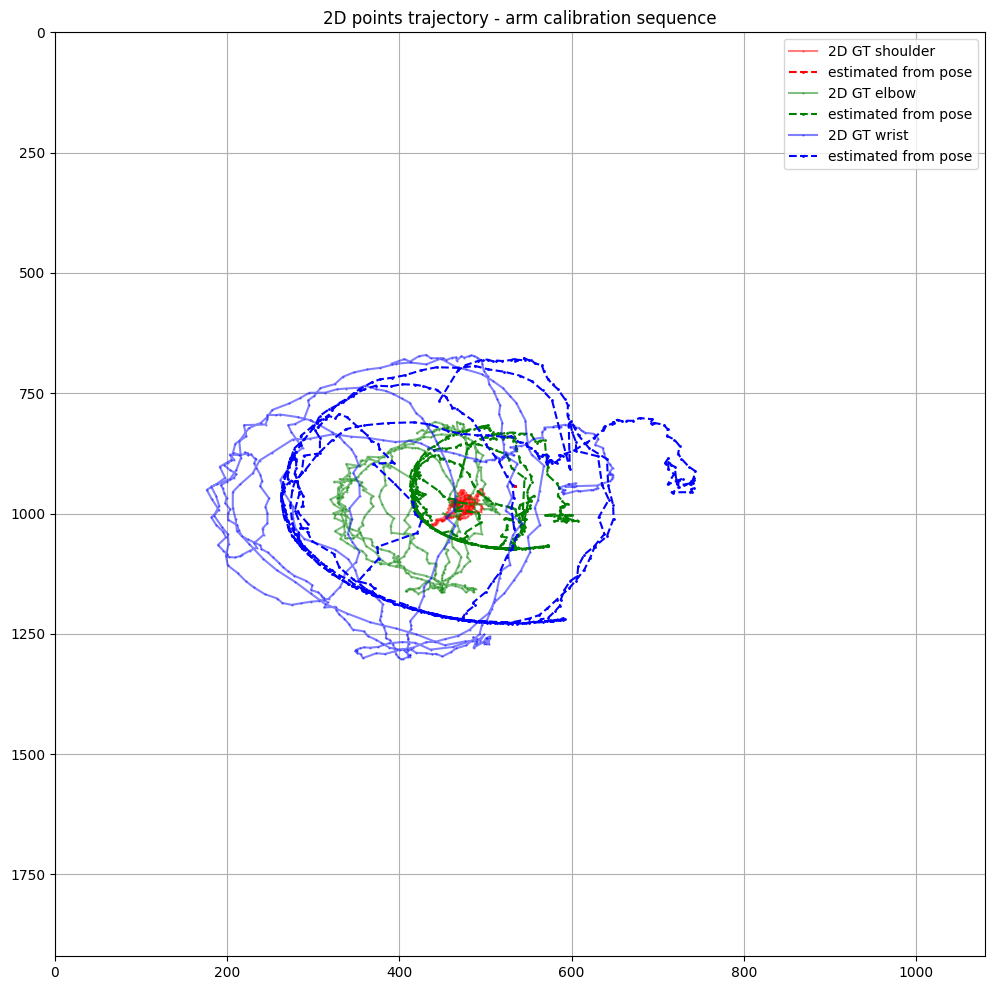

In [73]:
plt.figure(figsize=(12, 12))
t_start, t_end = 0, len(gt_p_full)
# t_start, t_end = 5, 100
h, w = 1920, 1080
for joint_idx, joint_name in enumerate([SHOULDER, ELBOW, WRIST]):
    x_gt_2D = gt_p2d_full[t_start:t_end, joint_idx * 3 + 0]*w
    y_gt_2D = gt_p2d_full[t_start:t_end, joint_idx * 3 + 1]*h

    x_reproj = p2d_estim_list[joint_name][t_start:t_end, 0]
    y_reproj = p2d_estim_list[joint_name][t_start:t_end, 1]
    plt.plot(x_gt_2D, y_gt_2D, ".-", color="rgb"[joint_idx], label=f"2D GT {joint_name}", markersize=1, alpha=0.5)
    plt.plot(x_reproj, y_reproj, "--.", color="rgb"[joint_idx], label="estimated from pose",markersize=2)

plt.xlim(0, w)
plt.ylim(h, 0)
plt.grid()
plt.legend()
plt.title("2D points trajectory - arm calibration sequence")
plt.show()

In [31]:
from scipy.optimize import least_squares

In [ ]:
p2d = project_3D_point(p3d, intrinsic_matrix, extrinsic_matrix)

In [57]:
from projectyl.utils.camera_projection import get_4D_homogeneous_vector

In [119]:
def diff_2D(point_prediction, point_2d_data):
    diff = point_prediction - point_2d_data
    diff = diff.flatten()
    return diff

def project_3D_to_2D(point_3d_data, intrinsic_matrix, extrinsic_matrix):
    point_2d_data = project_3D_point(point_3d_data, intrinsic_matrix, extrinsic_matrix)
    return point_2d_data

# extrinsic_position = np.array([0., 0., 0.])


def cost_function(extrinsic_params, point_4d_data, point_2d_data, intrinsic_matrix, debug=False):
    extrinsic_matrix = np.zeros((3, 4))
    extrinsic_matrix[:3, :3] = np.eye(3)
    extrinsic_matrix[:3, -1] = -get_4D_homogeneous_vector(extrinsic_params)[:3, 0]
    # point_2d_prediction = project_3D_to_2D(point_3d_data, intrinsic_matrix, extrinsic_matrix)

    ext_vec = extrinsic_matrix.dot(point_4d_data)
    if debug:
        print("EXT 3D VECT", extrinsic_matrix.shape, point_4d_data.shape, ext_vec.shape)
        print("vect 3D to project\n", ext_vec)
    pos2d_unnormed = intrinsic_matrix.dot(ext_vec)
    # print(pos2d.shape, point_2d_data.shape)
    if debug:
        print("pos2d prediction\n", pos2d_unnormed)
    pos2d = pos2d_unnormed[:2, :]
    pos2d[0, :]/= pos2d_unnormed[2, :]
    pos2d[1, :]/= pos2d_unnormed[2, :]
    if debug:
        print("pos2d normed\n", pos2d)
        print("pos2d target\n", point_2d_data)
    
    diff = diff_2D(pos2d.T, point_2d_data)
    return diff


In [133]:
debug = False
for time_idx in range(5,20):
    x_gt_2D_array, y_gt_2D_array = [], []
    point_4d_data = []
    for joint_idx, frame in enumerate([SHOULDER, ELBOW, WRIST]):
        # if joint_idx==0:
        #     continue
        current_q = q[time_idx]
        point, jac = forward_kinematics(arm_robot, current_q, frame=frame)
        p3d = point.translation
        point_4d_data.append(get_4D_homogeneous_vector(p3d))
        x_gt_2D = gt_p2d_full[time_idx, joint_idx * 3 + 0]*w
        y_gt_2D = gt_p2d_full[time_idx, joint_idx * 3 + 1]*h
        x_gt_2D_array.append(x_gt_2D)
        y_gt_2D_array.append(y_gt_2D)
    # x_gt_2D_array = np.stack(x_gt_2D_array)
    # y_gt_2D_array = np.stack(y_gt_2D_array)
    point_2d_data = np.array([x_gt_2D_array, y_gt_2D_array]).T # 3, 3
    point_4d_data = np.array(point_4d_data)[:, :, 0].T # 3, 2
    if debug:
        print(point_4d_data.shape)
        print(point_4d_data)
    # print(point_4d_data.shape, point_2d_data.shape)
    cam_init = [0., -3., 1.0]
    init_var = cam_init
    init_cost = cost_function(init_var, point_4d_data, point_2d_data, intrinsic_matrix, debug=False)
    # print()
    solution = least_squares(cost_function, init_var, args=(point_4d_data, point_2d_data, intrinsic_matrix)).x
    # if debug
    solution_cost = cost_function(solution, point_4d_data, point_2d_data, intrinsic_matrix)
    print(solution, np.linalg.norm(init_cost), np.linalg.norm(solution_cost))

[ 0.09784979 -2.90131355  0.99731487] 108.8284621601577 30.45160994874322
[ 0.0995297  -2.88886281  0.99498871] 111.65122370427342 30.550719635981274
[ 0.09262954 -2.878066    0.99874206] 103.92192103522964 27.871950416488556
[ 0.10084976 -2.91928142  0.99730385] 109.63749315028085 26.95489449300255
[ 0.09964285 -2.84280661  1.00756216] 110.10022285839473 22.309456102503297
[ 0.10461904 -2.88529985  1.00252492] 113.30003138740834 23.74204694499588
[ 0.09660496 -2.85320463  1.01301079] 106.21093683984986 20.787807611346437
[ 0.10248252 -2.89504807  0.99123042] 113.28039841536727 29.049633432120075
[ 0.10030746 -2.92339841  0.99210475] 108.71694467292646 26.215218709432207
[ 0.10272465 -2.87712411  0.99276996] 112.6635889870278 24.767589630484217
[ 0.10183991 -2.90262385  0.99474464] 109.68556097978127 22.13530147649983
[ 0.10149688 -2.87516363  0.99413407] 111.42481192450177 24.844279621596915
[ 0.09938405 -2.86393762  1.00254865] 108.41058719581538 23.241892569071993
[ 0.10018583 -2.88